In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [114]:
readings = []
offsets = []
for offset in range(1000):
    offsets.append(offset)
    gain = 30000

    prog = QickProgram(soccfg)
    prog.declare_gen(ch=0)

    freq_mhz = 200
    gen_freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)

    gen_length = prog.us2cycles(0.005, gen_ch=1)
    ro_length = prog.us2cycles(0.001, ro_ch=1)

    prog.set_pulse_registers(ch=0, style="const", length=gen_length, freq=gen_freq, phase=0, gain=gain)
    prog.declare_readout(ch=1, freq=freq_mhz, length=1, gen_ch=1)

    prog.synci(200)

    prog.trigger(pins=[0], t=150)
    prog.trigger(adcs=[1], t=100, adc_trig_offset=offset) 
    prog.pulse(ch=0, t=100)

    prog.wait_all(500) #pause execution of commands until the end of the readout window, plus N cycles
    prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
    prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
    prog.memwi(0, 1, 123)
    prog.memwi(0, 2, 124)
    prog.end()

    prog.compile()
    # soc.start_src("external")
    soc.start_src("internal")
    prog.load_pulses(soc)
    prog.config_gens(soc)
    soc.load_bin_program(prog.binprog)

    soc.tproc.start()

    results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in [123, 124]]
    result = np.absolute(results[0] + 1j*results[1])
    readings.append(result)
    # print("I, Q:", result)

max_item = max(readings)
max_index = readings.index(max_item)
optimal_offset = offsets[max_index]
print(readings)
print(optimal_offset)

[7166.833052332111, 6674.39742598536, 7076.313870935913, 6891.471831183815, 7014.913042939306, 7024.935302193181, 6773.750881158828, 6855.189712910942, 6934.527236949899, 7100.863679863176, 6765.306571028396, 6981.8216820540465, 6925.665383196044, 6883.865919670429, 6825.822221534927, 6901.306687867161, 6928.161949608279, 6945.181927062818, 7059.167797977322, 6953.888840066398, 6796.6083453440215, 6873.0398660272585, 6867.555678696752, 6938.088785825676, 7027.540465909819, 6931.356721450715, 6974.213432352067, 7007.489207983128, 6807.572327930126, 6875.254177119563, 6876.842371321303, 6805.19801328367, 6980.517172817498, 6889.407811996616, 7071.219484643367, 6856.178308649798, 7013.544182508584, 6863.586963097357, 6906.017738175888, 7097.497939414988, 6811.50122953817, 6850.566764874276, 7129.898877263267, 7177.857758412324, 6894.461835415437, 6930.925840030321, 7114.174020924706, 6933.300873321451, 7346.656450386121, 7214.416954959008, 7217.168004141236, 6822.560956121975, 7081.142986

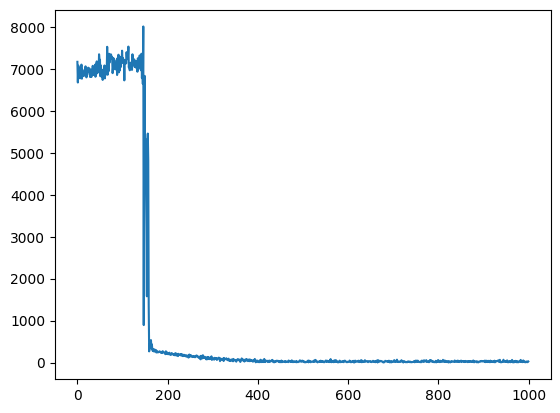

In [115]:
plt.plot(readings)

In [73]:
readings = []
gains = [False, True]
for wait_time in range(200):
    correct = True
    readings.append([])
    for gain in gains:
        prog = QickProgram(soccfg)
        prog.declare_gen(ch=0)
        prog.declare_gen(ch=1)

        freq_mhz = 200
        gen_freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)
        gen_length = prog.us2cycles(0.005, gen_ch=1)
        ro_length = prog.us2cycles(0.001, ro_ch=1)

        for ch in range(2):
            prog.set_pulse_registers(ch=ch, style="const", length=gen_length, freq=gen_freq, phase=0, gain=gain)
        prog.declare_readout(ch=1, freq=freq_mhz, length=1, gen_ch=1)

        prog.synci(30)

        prog.pulse(ch=0)
        if gain:
            prog.trigger(pins=[0])
        # prog.pulse(ch=1)
        prog.trigger(adcs=[1], adc_trig_offset=0) 

        prog.wait_all(wait_time)
        prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
        prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
        prog.memwi(0, 1, 123)
        prog.memwi(0, 2, 124)

        # prog.condj(0, 1, '<', 0, "JUMP_LOC")
        # prog.pulse(ch=0)
        # prog.label("JUMP_LOC")
        prog.end()

        prog.compile()
        # soc.start_src("external")
        soc.start_src("internal")
        prog.load_pulses(soc)
        prog.config_gens(soc)
        soc.load_bin_program(prog.binprog)

        soc.tproc.start()

        prev_result = result
        results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in [123, 124]]
        result = np.absolute(results[0] + 1j*results[1])
        readings[-1].append(result)

In [74]:
for i in range(len(readings)):
    if readings[i][0] > readings[i][1]:
        print(i, "FAIL")
    else:
        print(i, "PASS")

0 FAIL
1 FAIL
2 FAIL
3 FAIL
4 FAIL
5 FAIL
6 FAIL
7 FAIL
8 FAIL
9 FAIL
10 FAIL
11 FAIL
12 FAIL
13 FAIL
14 FAIL
15 FAIL
16 FAIL
17 FAIL
18 FAIL
19 FAIL
20 FAIL
21 FAIL
22 FAIL
23 FAIL
24 FAIL
25 FAIL
26 FAIL
27 FAIL
28 FAIL
29 FAIL
30 FAIL
31 FAIL
32 FAIL
33 FAIL
34 FAIL
35 FAIL
36 FAIL
37 FAIL
38 FAIL
39 FAIL
40 FAIL
41 FAIL
42 FAIL
43 FAIL
44 FAIL
45 FAIL
46 FAIL
47 FAIL
48 FAIL
49 FAIL
50 FAIL
51 FAIL
52 FAIL
53 FAIL
54 FAIL
55 FAIL
56 FAIL
57 FAIL
58 FAIL
59 FAIL
60 FAIL
61 FAIL
62 FAIL
63 FAIL
64 FAIL
65 FAIL
66 FAIL
67 FAIL
68 FAIL
69 FAIL
70 FAIL
71 FAIL
72 FAIL
73 FAIL
74 FAIL
75 FAIL
76 FAIL
77 FAIL
78 FAIL
79 FAIL
80 FAIL
81 FAIL
82 FAIL
83 FAIL
84 FAIL
85 FAIL
86 FAIL
87 FAIL
88 FAIL
89 FAIL
90 FAIL
91 FAIL
92 FAIL
93 FAIL
94 FAIL
95 FAIL
96 FAIL
97 FAIL
98 FAIL
99 FAIL
100 FAIL
101 FAIL
102 FAIL
103 FAIL
104 FAIL
105 FAIL
106 FAIL
107 FAIL
108 FAIL
109 FAIL
110 FAIL
111 FAIL
112 FAIL
113 FAIL
114 FAIL
115 FAIL
116 FAIL
117 FAIL
118 FAIL
119 FAIL
120 FAIL
121 FAIL
122 FAIL
123

In [103]:
prog = QickProgram(soccfg)
prog.declare_gen(ch=0)
prog.declare_gen(ch=1)

freq_mhz = 200
gen_freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)
gen_length = prog.us2cycles(0.005, gen_ch=1)
ro_length = prog.us2cycles(0.001, ro_ch=1)

for ch in range(2):
    prog.set_pulse_registers(ch=ch, style="const", length=gen_length, freq=gen_freq, phase=0, gain=gain)
prog.declare_readout(ch=1, freq=freq_mhz, length=ro_length, gen_ch=1)

prog.synci(30)

prog.pulse(ch=0)
# prog.pulse(ch=1)
prog.trigger(pins=[0])
prog.trigger(adcs=[1], adc_trig_offset=5) 

prog.wait_all(165)
prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
prog.memwi(0, 1, 123)
prog.memwi(0, 2, 124)

prog.condj(0, 1, '<', 0, "JUMP_LOC")
# prog.pulse(ch=0)
prog.trigger(pins=[0])
prog.label("JUMP_LOC")
prog.end()

prog.compile()
# soc.start_src("external")
soc.start_src("internal")
prog.load_pulses(soc)
prog.config_gens(soc)
soc.load_bin_program(prog.binprog)

soc.tproc.start()

prev_result = result
results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in [123, 124]]
result = np.absolute(results[0] + 1j*results[1])
print("I, Q:", result)

I, Q: 7056.4955891717245
